In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [139]:
# load data
train_df = pd.read_csv('icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv('icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv('icr-identify-age-related-conditions/greeks.csv')

train_with_greeks_df = train_df.merge(greeks_df, how = 'inner', on = 'Id')
train_with_greeks_df['Epsilon'] = train_with_greeks_df['Epsilon'].replace('Unknown', np.nan)
train_with_greeks_df['Epsilon'] = pd.to_datetime(train_with_greeks_df['Epsilon'], format = '%m/%d/%Y')

In [140]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

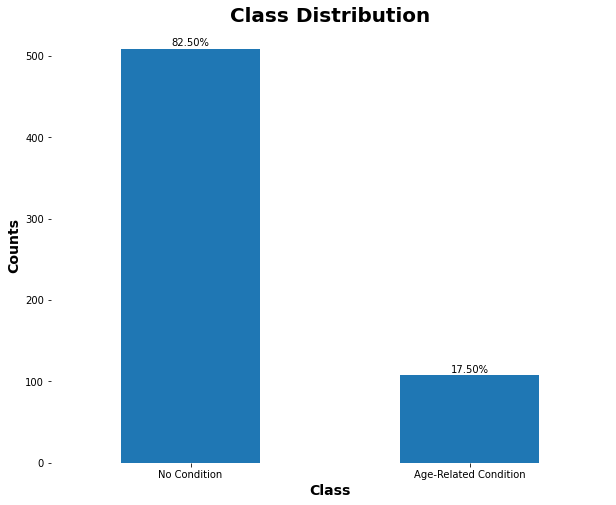

In [141]:
# counts by outcome class
plt.figure(figsize=(10, 8))

class_counts = train_df['Class'].value_counts()
class_counts.plot(kind = 'bar')

plt.title('Class Distribution', fontdict = font_dict_header)
plt.xlabel('Class', fontdict = font_dict_axistitle)
label_dict = {0: 'No Condition', 1: 'Age-Related Condition'}
plt.xticks(rotation = 0, ticks = train_df['Class'].unique(), labels = [label_dict[i] for i in train_df['Class'].unique()])
plt.ylabel('Counts', fontdict=font_dict_axistitle)

total_count = float(len(train_df))
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2.,
             height + 3,
             '{:1.2f}%'.format((height/total_count) * 100),
             ha = 'center') 

plt.box(False)
plt.show()

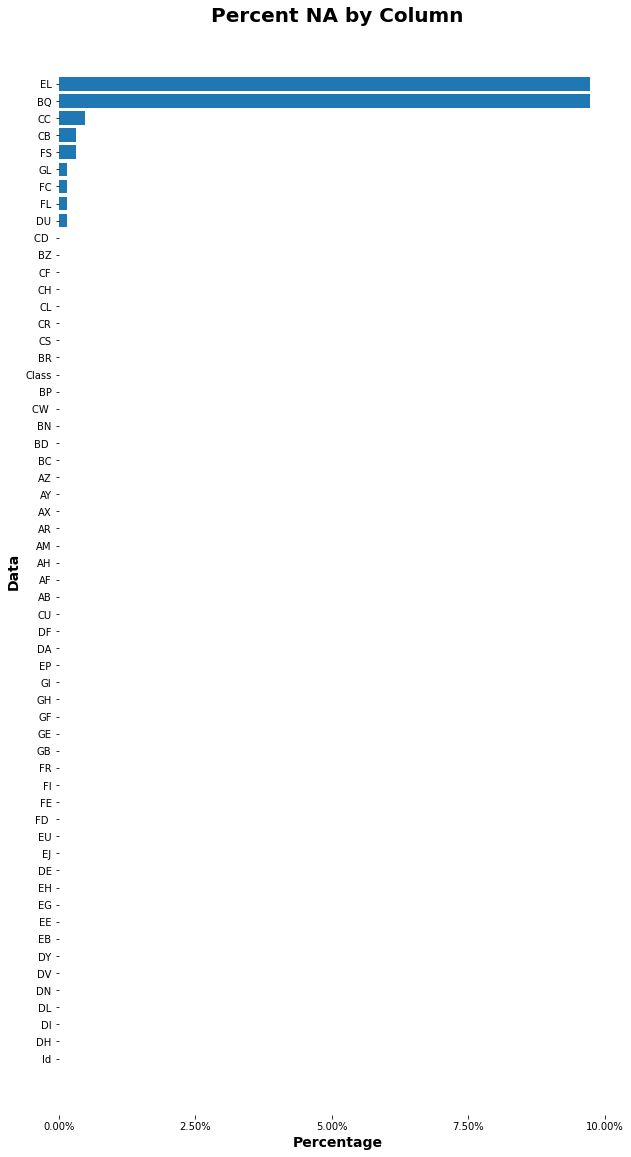

In [142]:
# missing values
na_by_column = train_df.isnull().sum().reset_index()
na_by_column.columns = ['Column', 'Count NA']
na_by_column['Percent NA'] = na_by_column['Count NA'] / len(train_df)
na_by_column = na_by_column.sort_values('Percent NA', ascending=True) 

plt.figure(figsize = [10, 20])
plt.barh(data = na_by_column, y = 'Column', width = 'Percent NA')
plt.box(False)

x_max = na_by_column['Percent NA'].max()
x_increments = 0.025
x_ticks = np.arange(0, x_max + x_increments, x_increments)

plt.xlabel('Percentage', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(ticks = x_ticks, labels = ['{:1.2f}%'.format(tick * 100) for tick in x_ticks])
plt.ylabel('Data', fontdict = {'size': 14, 'weight': 'bold'})
plt.title('Percent NA by Column', fontdict = {'size': 20, 'weight': 'bold'})
plt.show()


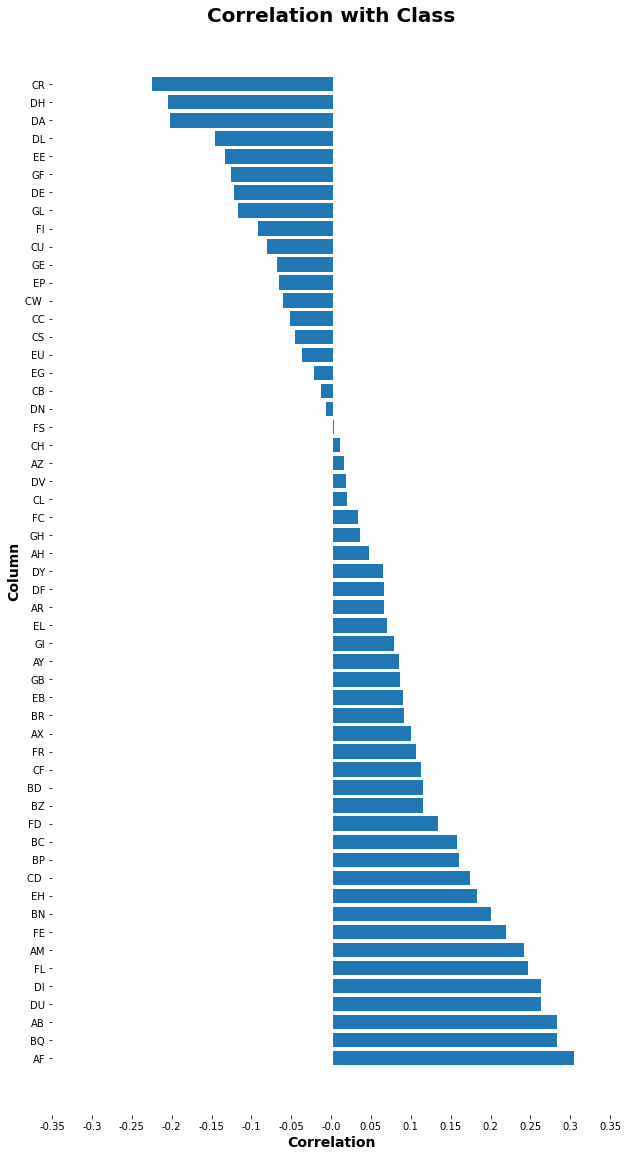

In [143]:
# finding linear correlations
correlations_with_class = train_df[train_df.select_dtypes(include = ['int64', 'float64']).columns].corr()['Class'].sort_values(ascending = False)
correlations_with_class.drop('Class', inplace = True)
correlations_with_class = pd.DataFrame(correlations_with_class).reset_index().rename(columns = {'index': 'Column', 'Class': 'Correlation with Class'})

plt.figure(figsize = [10, 20])
plt.title('Correlation with Class', fontdict = {'size': 20, 'weight': 'bold'})
plt.barh(data = correlations_with_class, y = 'Column', width = 'Correlation with Class')
plt.box(False)

x_max = max([correlations_with_class['Correlation with Class'].max(), abs(correlations_with_class['Correlation with Class'].min())])
x_increments = 0.05
x_ticks = np.arange((x_max + x_increments) * -1, x_max + x_increments, x_increments)

plt.xlabel('Correlation', fontdict = {'size': 14, 'weight': 'bold'})
plt.xticks(ticks = x_ticks, labels = [np.round(tick, 2) for tick in x_ticks])
plt.ylabel('Column', fontdict = {'size': 14, 'weight': 'bold'})
plt.show()

In [144]:
# explain categorical variables
EJ_df = train_df.groupby('EJ').agg({'Class': ['mean', 'count']})
EJ_df.columns = [' '.join(col).strip() for col in EJ_df.columns.values]
EJ_df.reset_index(inplace = True)
EJ_df.rename(columns = {'Class mean': 'Mean', 'Class count': 'Count'}, inplace = True)

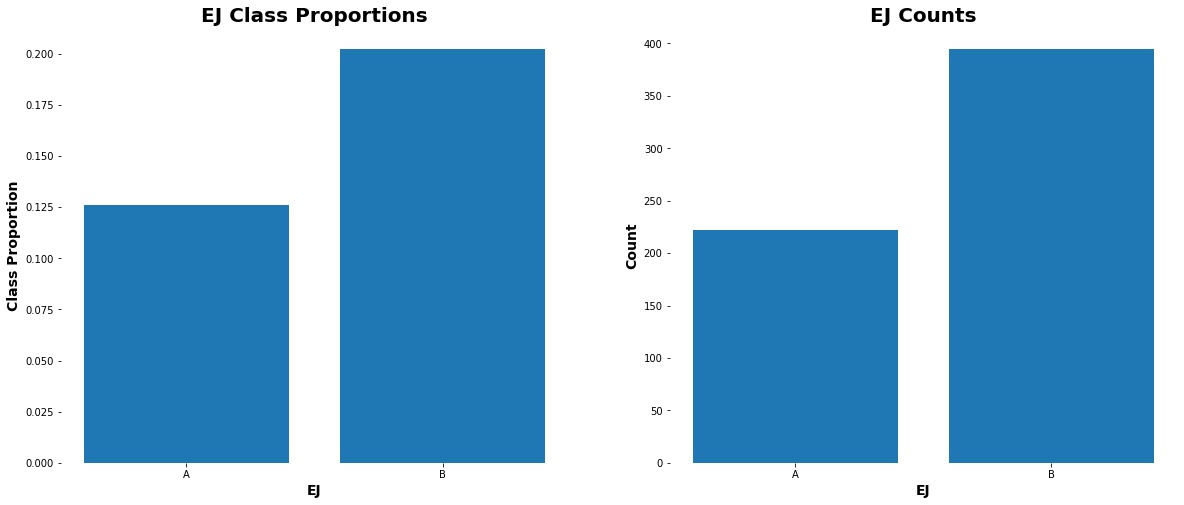

In [145]:
# plot proportion and count
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('EJ Class Proportions', fontdict = font_dict_header)
plt.bar(data = EJ_df, x = 'EJ', height = 'Mean')
plt.box(False)
plt.xlabel('EJ', fontdict = font_dict_axistitle)
plt.ylabel('Class Proportion', fontdict = font_dict_axistitle)

plt.subplot(1, 2, 2)
plt.title('EJ Counts', fontdict = font_dict_header)
plt.bar(data = EJ_df, x = 'EJ', height = 'Count')
plt.box(False)
plt.xlabel('EJ', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)

plt.show()

In [146]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


In [10]:
# pre-process data
y_train = train_df['Class']

x_dummies = pd.get_dummies(train_df[['EJ']])
x_train = pd.concat([train_df, x_dummies], axis = 1)
x_train = x_train.select_dtypes(include = [np.number])
x_train = x_train.drop(['Class'], axis = 1, inplace = False)

# add na counts
for col in x_train.columns:
    x_train[col + ' NA'] = x_train[col].isna().astype(int)
    
all_zero_cols = x_train.columns[x_train.max() == 0]
x_train = x_train.drop(all_zero_cols, axis = 1)


# normalize data
x_train_columns = x_train.columns
x_train = PowerTransformer().fit_transform(x_train)
x_train = StandardScaler().fit_transform(x_train)
x_train = KNNImputer().fit_transform(x_train)

Number of Principal Components: 50
Total Explained Variance: 96.54%


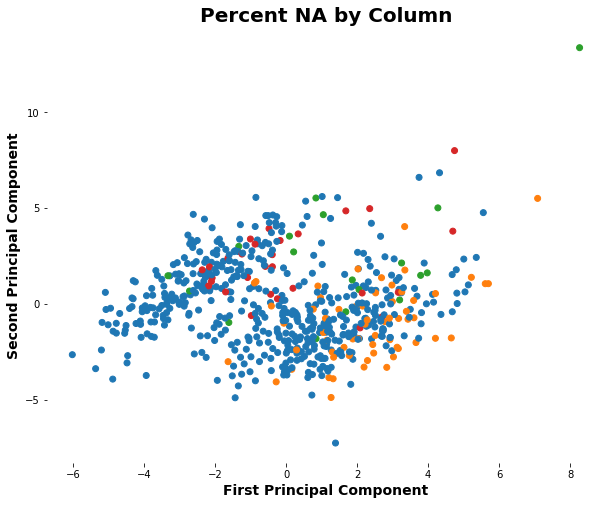

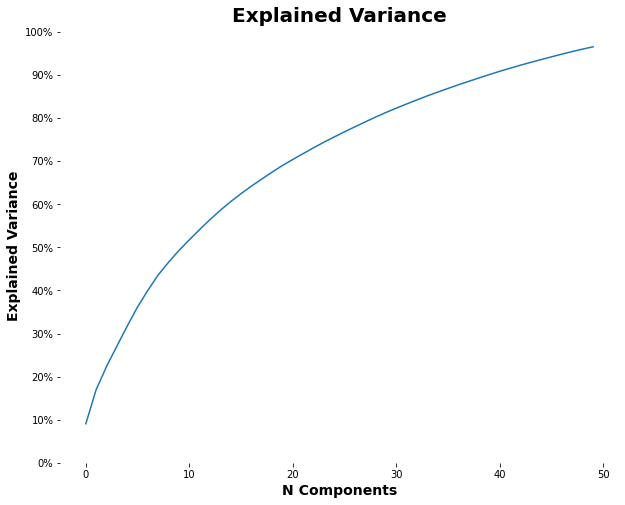

In [136]:
# PCA
pca_n = 50
pca = PCA(n_components = pca_n) 
principal_components = pca.fit_transform(x_train)
pca_columns = ['Principal Component ' + str(i + 1) for i in range(pca_n)]

pca_df = pd.DataFrame(data = principal_components, columns = pca_columns)
pca_df['Class'] = y_train

# print explained variance
print(f'Number of Principal Components: {pca_n}')
print(f'Total Explained Variance: {np.round(sum(pca.explained_variance_ratio_) * 100, 2)}%')

color_dict = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
colors = train_with_greeks_df['Alpha'].map(color_dict)

# plot PCA and explained variance
plt.figure(figsize = (10, 8))
plt.title('Percent NA by Column', fontdict = font_dict_header)
plt.box(False)
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c = colors)
plt.xlabel('First Principal Component', fontdict = font_dict_axistitle)
plt.ylabel('Second Principal Component', fontdict = font_dict_axistitle)
plt.show()

plt.figure(figsize = (10, 8))
plt.title('Explained Variance', fontdict = font_dict_header)
plt.box(False)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('N Components', fontdict = font_dict_axistitle)
plt.ylabel('Explained Variance', fontdict = font_dict_axistitle)
plt.yticks(np.arange(0, 1.1, 0.1), labels = ['{:1.0f}%'.format(tick * 100) for tick in np.arange(0, 1.1, 0.1)])
plt.show()

In [12]:
# create df of the PCA components
pca_components_df = pd.DataFrame(pca.components_, columns = x_train_columns, index = pca_columns)
pca_components_df.abs().T.sort_values(by = 'Principal Component 1', ascending = False).head(10)

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,...,Principal Component 41,Principal Component 42,Principal Component 43,Principal Component 44,Principal Component 45,Principal Component 46,Principal Component 47,Principal Component 48,Principal Component 49,Principal Component 50
FD,0.308449,0.213187,0.137387,0.011549,0.036538,0.091731,0.085340,0.025350,0.061441,0.012873,...,0.002075,0.011667,0.010716,0.053775,0.004964,0.018664,0.055403,0.001520,0.008646,0.005011
FL,0.307143,0.224625,0.129511,0.025321,0.060060,0.003259,0.028535,0.018847,0.046867,0.033535,...,0.036533,0.020088,0.070466,0.068646,0.046233,0.051222,0.058968,0.063740,0.072925,0.161156
DU,0.305524,0.204067,0.149081,0.013191,0.035627,0.034455,0.018979,0.015585,0.074630,0.004339,...,0.058935,0.019005,0.038265,0.088523,0.006386,0.064033,0.044566,0.039251,0.005737,0.096918
EH,0.297090,0.198517,0.152639,0.010118,0.065380,0.090362,0.064470,0.017055,0.076787,0.016861,...,0.059165,0.018051,0.035977,0.145433,0.044579,0.023748,0.071330,0.057086,0.049446,0.163666
GL,0.296068,0.249420,0.095490,0.024580,0.051155,0.024489,0.026709,0.025968,0.019787,0.029905,...,0.016211,0.039313,0.065475,0.095815,0.002082,0.046067,0.037513,0.055231,0.018026,0.087254
AB,0.251729,0.137235,0.137212,0.115170,0.080090,0.057803,0.226970,0.040772,0.071258,0.020395,...,0.158699,0.010072,0.011826,0.009255,0.000315,0.075932,0.011669,0.002793,0.006862,0.081820
BN,0.184715,0.094368,0.029277,0.082778,0.040524,0.119066,0.148147,0.060578,0.004513,0.162625,...,0.131733,0.049518,0.052523,0.093399,0.055178,0.371150,0.058432,0.039243,0.095473,0.014996
AM,0.178528,0.124922,0.076974,0.029620,0.027979,0.107887,0.260394,0.095542,0.183482,0.048552,...,0.075830,0.148583,0.093047,0.404584,0.096428,0.140368,0.291146,0.123607,0.125192,0.288404
BP,0.175451,0.154808,0.008467,0.007073,0.117736,0.068256,0.048944,0.010475,0.037675,0.021470,...,0.064596,0.348613,0.009263,0.097198,0.104320,0.149167,0.000641,0.099342,0.229995,0.100386
EG,0.163835,0.093722,0.093805,0.062836,0.112373,0.102561,0.053301,0.024710,0.091860,0.152077,...,0.019660,0.142260,0.010792,0.042276,0.162212,0.133939,0.156735,0.221453,0.072270,0.004621


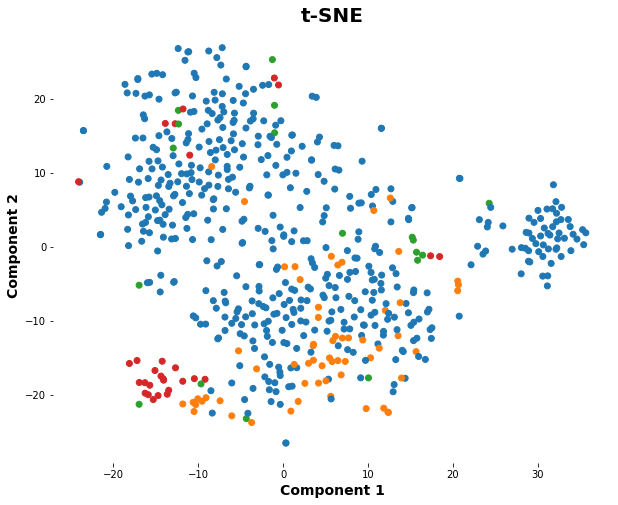

In [135]:
# t-SNE
tsne_n = 2
tsne = TSNE(n_components = tsne_n)
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
x_tsne = tsne.fit_transform(x_train)
tsne.fit(x_train)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = x_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train

color_dict = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
colors = train_with_greeks_df['Alpha'].map(color_dict)

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

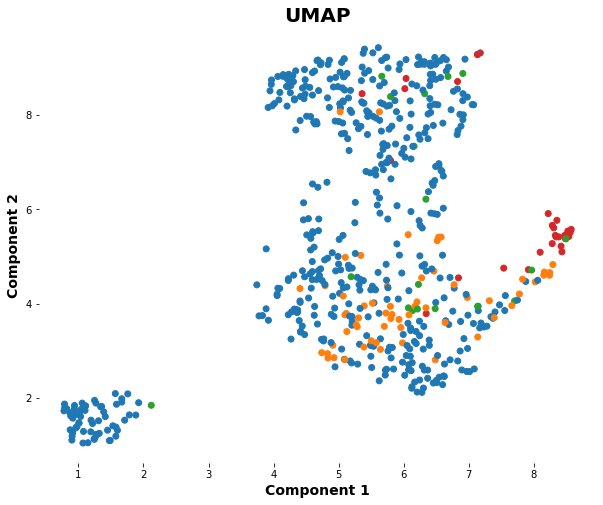

In [147]:
# umap
umap_n = 2
reducer = umap.UMAP(n_components = umap_n)
umap_columns = ['Component ' + str(i + 1) for i in range(umap_n)]
x_umap = reducer.fit_transform(x_train)

# create df with the UMAP components and 'Class'
umap_df = pd.DataFrame(data = x_umap, columns = umap_columns)
umap_df['Class'] = y_train

color_dict = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
colors = train_with_greeks_df['Alpha'].map(color_dict)

# plot components
plt.figure(figsize = (10, 8))
plt.title('UMAP', fontdict = font_dict_header)
plt.box(False)
plt.scatter(umap_df['Component 1'], umap_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()


In [177]:
# create counts by Alpha values
alpha_counts = train_with_greeks_df.groupby(['Epsilon', 'Alpha']).agg({'Id': 'count'}).reset_index().rename(columns = {'Id': 'Count'})
alpha_counts = alpha_counts.groupby([pd.Grouper(key = 'Epsilon', freq = 'M'), 'Alpha']).agg({'Count': 'sum'}).unstack().reset_index().fillna(0)
alpha_counts = alpha_counts[alpha_counts['Epsilon'] >= '2018-01-01']
alpha_counts = alpha_counts.set_index('Epsilon').resample('M').ffill()
alpha_counts.columns = alpha_counts.columns.droplevel(0)
alpha_counts.reset_index(inplace = True)

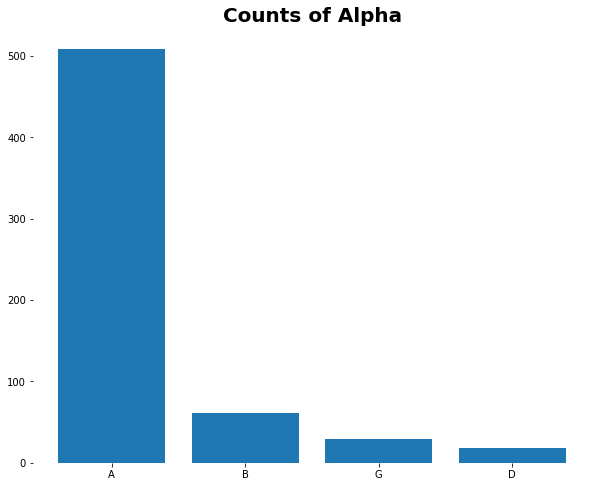

In [179]:
# plot Alpha counts
plt.figure(figsize = (10, 8))
plt.title('Counts of Alpha', fontdict = font_dict_header)
plt.box(False)
plt.bar(x = train_with_greeks_df['Alpha'].value_counts().index, height = train_with_greeks_df['Alpha'].value_counts())
plt.show()

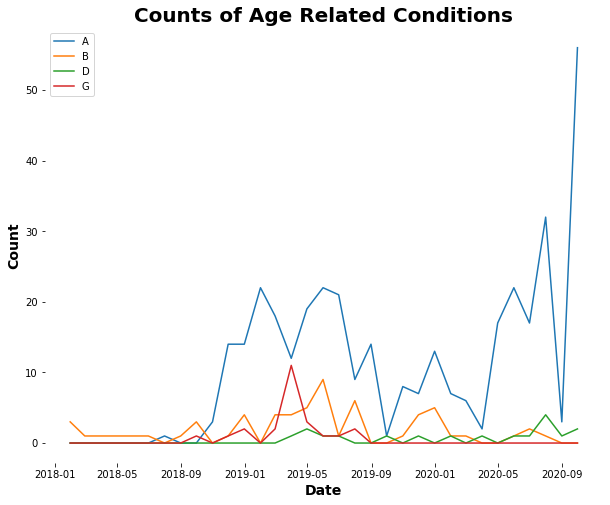

In [180]:
# plot Alpha counts over time
plt.figure(figsize = (10, 8))
plt.title('Counts of Age Related Conditions', fontdict = font_dict_header)
plt.box(False)
plt.plot(alpha_counts['Epsilon'], alpha_counts['A'], label = 'A')
plt.plot(alpha_counts['Epsilon'], alpha_counts['B'], label = 'B')
plt.plot(alpha_counts['Epsilon'], alpha_counts['D'], label = 'D')
plt.plot(alpha_counts['Epsilon'], alpha_counts['G'], label = 'G')
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.xlabel('Date', fontdict = font_dict_axistitle)
plt.legend()
plt.show()

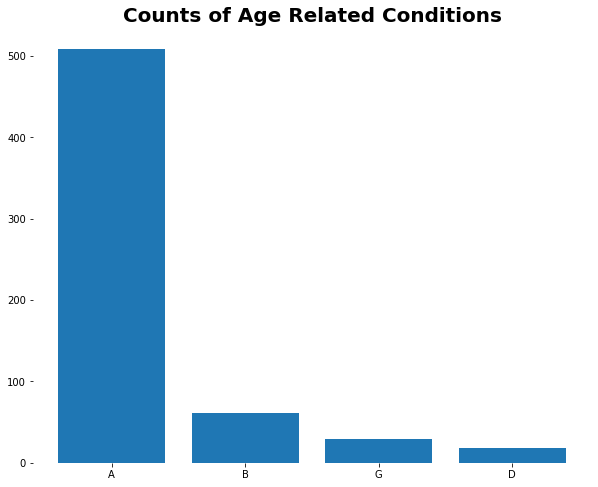

In [173]:
plt.figure(figsize = (10, 8))
plt.title('Counts of Alpha', fontdict = font_dict_header)
plt.box(False)
plt.bar(x = train_with_greeks_df['Alpha'].value_counts().index, height = train_with_greeks_df['Alpha'].value_counts())
plt.show()

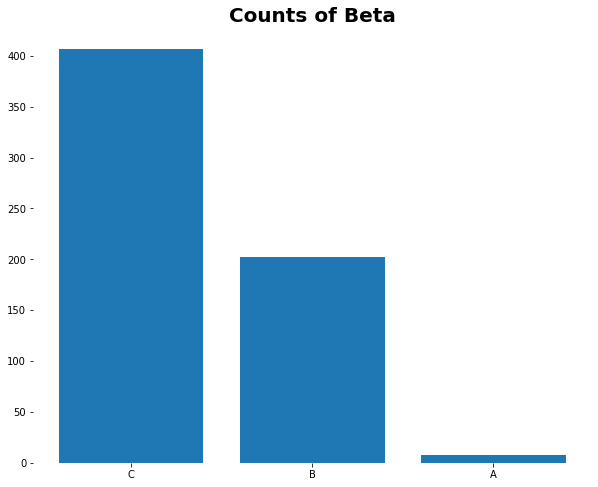

In [175]:
plt.figure(figsize = (10, 8))
plt.title('Counts of Beta', fontdict = font_dict_header)
plt.box(False)
plt.bar(x = train_with_greeks_df['Beta'].value_counts().index, height = train_with_greeks_df['Beta'].value_counts())
plt.show()